# Data analysis of the HHBLITS and MMSeqs datasets

First of all, the sequence lengths of the datasets are inspected, since the ESM1b embeddings works with residue sequences that are below 1024 and 500.

**Loading of libraries**

In [31]:
import numpy as np
import matplotlib.pyplot as plt

## Loading dataset(s)

In [5]:
hhblits = np.load('/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits.npz')['data']

## Sequence length distribution

Count the sequences and then plot the distribution as a histogram

In [3]:
def count_sequences(data):
    """Counts the sequences in given data"""
    hist = {}
    for seq in data:
        idx = sum(seq)
        hist[idx] = hist.get(idx, 0) + 1
    return hist

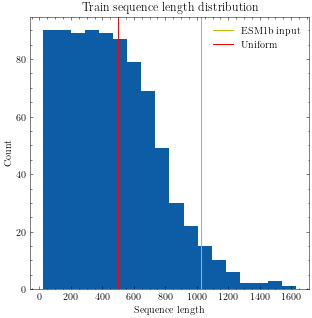

In [14]:
# Plot hhblits
plt.style.use('science')

hhblits_count = count_sequences(hhblits[:, :, 50])

plt.rcParams["figure.figsize"]=(5, 5)
n, bins, patches = plt.hist(x=hhblits_count, bins='auto')
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.title('Train sequence length distribution')
plt.axvline(x=1024, label='ESM1b input', c='y')
plt.axvline(x=500, label='Uniform', c='r')
plt.legend(loc='upper right')
plt.show()

**How many sequences are removed if lengths are reduced to only keep below 1024 and 600?**

In [15]:
total = sum(hhblits_count.values())

# lamda filter that filters out the keys
filter_total = lambda x, y: dict([ (i,x[i]) for i in x if i < y ])

# count if the sequences are reduced
reduce_1024 = sum(filter_total(hhblits_count, 1024).values())
reduce_500 = sum(filter_total(hhblits_count, 500).values())

print("total:", total)
print("<1024:", total-reduce_1024)
print("<500:", total-reduce_500)

total: 10848
<1024: 34
<500: 782


In [13]:
hhblits = hhblits[np.sum(hhblits[:, :, 50], axis=1) < 500]

In [14]:
hhblits.shape

(10066, 1632, 68)

In [15]:
np.savez_compressed("/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits_500.npz", data=hhblits[:, :500, :])
np.savez_compressed("/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits_500_small.npz", data=hhblits[:1000, :500, :])

## Split embedding dataset

In [1]:
import h5py
import pdb
import numpy as np

In [6]:
f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b.hdf5", "r")["dataset"]
f_sequences, f_residues, f_classes = f.shape

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Lets create a dataset where we reduce to only include below 500 residues**

In [10]:
batch = 250
max_residues = 500

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (1, max_residues, f_classes), maxshape=(None, max_residues, f_classes), dtype='float64', compression="gzip")
        
    n = 0
    for sequences in range(0, f_sequences, batch):
        
        # retrieve and filter sequences
        data = f[sequences:sequences+batch]
        data = data[np.sum(data[:, :, 50], axis=1) < max_residues]
        
        # expand dataset dimension
        data_sequences = data.shape[0]
        dataset.resize((n+data_sequences, max_residues, f_classes))
        
        # save the filtered data
        dataset[n:n+data_sequences] = data[:data_sequences, :max_residues]
        
        n += data_sequences

**Create small subsets**

In [12]:
f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b.hdf5", "r")["dataset"]

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_S.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (200, f.shape[1], f.shape[2]), dtype='float64', compression="gzip")
    dataset[:200] = f[:200]

f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500.hdf5", "r")["dataset"]

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500_S.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (200, f.shape[1], f.shape[2]), dtype='float64', compression="gzip")
    dataset[:200] = f[:200]
    

In [3]:
f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHblits_ESM1b.hdf5", "r")["dataset"]
print(f[0, :, 68:])

[[ 0.00787175  0.05809084 -0.02836424 ...  0.1666221  -0.44573057
  -0.20741236]
 [ 0.05949696 -0.05585581 -0.18400535 ... -0.03884577 -0.15477931
   0.33799493]
 [-0.06148477  0.10019163  0.07873724 ...  0.16803379 -0.14928876
   0.25068259]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import esm

In [3]:
AA_TRANSLATE = {
    0: "X",
    1: "A",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "K",
    10: "L",
    11: "M",
    12: "N",
    13: "P",
    14: "Q",
    15: "R",
    16: "S",
    17: "T",
    18: "V",
    19: "W",
    20: "Y",
}


class ESM1bEmbedding(nn.Module):
    """ ESM1b embedding layer module """
    
    def __init__(self, model_path: str, ft_embed_tokens: bool = False, ft_transformer: bool = False, ft_contact_head: bool = False, 
                 ft_embed_positions: bool = False, ft_emb_layer_norm_before: bool = False, ft_emb_layer_norm_after: bool = False, ft_lm_head: bool = False, max_embedding: int = 1024, offset: int = 200):
        """ Constructor
        Args:
            model_path: path to language model
            max_embeddings: maximum sequence length for language model
            offset: overlap offset when concatenating sequences above max embedding
        """
        super(ESM1bEmbedding, self).__init__()

        # configure pre-trained model
        self.model, alphabet = esm.pretrained.load_model_and_alphabet_local(model_path)
        self.batch_converter = alphabet.get_batch_converter()

        self.max_embedding = max_embedding
        self.offset = offset
        
        # finetuning, freezes all layers by default
        self.finetune = [ft_embed_tokens, ft_transformer, ft_contact_head, ft_embed_positions, ft_emb_layer_norm_before, ft_emb_layer_norm_after, ft_lm_head]
        self._finetune()
            
    def _finetune(self):
        # finetune by freezing unchoosen layers
        print("finetune")
        for i, child in enumerate(self.model.children()):
            if self.finetune[i] == False:
                print(child)
                for param in child.parameters():
                    param.requires_grad = False

    def _decode_sparse_encoding(self, x: torch.tensor) -> list:
        # get sparse positions
        x = (torch.argmax(x[:, :, :20], axis=2) + 1) * torch.amax(x[:, :, :20], axis=2)

        sequences = []

        # decode sparse encoding to residue sequence
        batches = x.shape[0]
        for i in range(batches):
            sequence = "".join(map(lambda r: AA_TRANSLATE[r.item()], x[i])).rstrip("X")
            sequences.append(("protein_" + str(i), sequence))

        return sequences

    def forward(self, x: torch.tensor) -> torch.tensor:
        device = x.device
        sequence_length = x.shape[1]

        x = self._decode_sparse_encoding(x)

        # make tokens and move to cude if possible
        batch_labels, batch_strs, batch_tokens = self.batch_converter(x)
        batch_tokens = batch_tokens.to(device)
        batch_sequences, batch_residues = batch_tokens.shape

        embedding = self.model(batch_tokens[:, :self.max_embedding], repr_layers=[33])["representations"][33]
            
        # if size above 1024 then generate embeddings that overlaps with the offset
        if batch_residues >= self.max_embedding:
            # combine by overlaps
            for i in range(1, math.floor(batch_residues / self.max_embedding) + 1):
                o1 = (self.max_embedding - self.offset) * i
                o2 = o1 + self.max_embedding
                embedding = torch.cat([embedding[:, :o1], self.model(
                    batch_tokens[:, o1:o2], repr_layers=[33])["representations"][33]], dim=1)
            embedding = torch.nan_to_num(embedding)

        # add padding
        embedding = F.pad(embedding, pad=(0, 0, 0, sequence_length-embedding.shape[1]), mode='constant', value=0)
    
        # cleanup
        del batch_tokens
        torch.cuda.empty_cache()

        return embedding

In [4]:
model = ESM1bEmbedding("/home/eryk/development/NSPThesis/models/esm1b_t33_650M_UR50S.pt")

/home/eryk/anaconda3/envs/nsp3/lib/python3.8/site-packages/esm/pretrained.py:112: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn("Regression weights not found, predicting contacts will not produce correct results.")


finetune
ModuleList(
  (0): TransformerLayer(
    (self_attn): MultiheadAttention(
      (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (fc1): Linear(in_features=1280, out_features=5120, bias=True)
    (fc2): Linear(in_features=5120, out_features=1280, bias=True)
    (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (1): TransformerLayer(
    (self_attn): MultiheadAttention(
      (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
      (out_proj): Linear(in_features=1280, out_featu

In [10]:
model.to('cpu')

ESM1bEmbedding(
  (model): ProteinBertModel(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in

In [11]:
with torch.no_grad():
    print(model(torch.tensor(f[0, :, :20]).unsqueeze(0)))

tensor([[[-0.0252,  0.2534,  0.1238,  ...,  0.0311,  0.0084, -0.0639],
         [ 0.0079,  0.0581, -0.0284,  ...,  0.1666, -0.4457, -0.2074],
         [ 0.0595, -0.0559, -0.1840,  ..., -0.0388, -0.1548,  0.3380],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])


In [12]:
with torch.no_grad():
    print(model(torch.tensor(f[:2, :, :20])))

tensor([[[-0.0252,  0.2534,  0.1238,  ...,  0.0311,  0.0084, -0.0639],
         [ 0.0079,  0.0581, -0.0284,  ...,  0.1666, -0.4457, -0.2074],
         [ 0.0595, -0.0559, -0.1840,  ..., -0.0388, -0.1548,  0.3380],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.1430,  0.1740,  0.1948,  ...,  0.1256,  0.0091, -0.0543],
         [-0.0634, -0.0551,  0.5158,  ..., -0.1531,  0.1662, -0.2550],
         [ 0.2619, -0.1102,  0.0700,  ...,  0.0500,  0.1526,  0.0623],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])
